# Assignment 3 - Computer Vision - Efficient Graph-Based Image Segmentation

In [623]:
from PIL import Image #with image we create image objects
import matplotlib.pyplot as plt #we use matplotlib to dispay images
import numpy as np

import skimage.data as data
import skimage.segmentation as segm
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage import io

import sys
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
from scipy.signal import convolve2d

from tqdm import trange

Unsupervised segmentation means, no prior knowledge is required. F. FELZENSZWALB & HUTTENLOCHER is an unsupervised algorithm for image segmentation. These kind of algorithms attempt to subdivide images into meaningful regions automatically. The user may still be able to edit certain settings to obtain desired outputs.  For example if we have an image that is very large that we can not consider all pixels at the same time, Unsupervised segmentation can break the image into sub-regions, so instead of millions of pixels, we have tens to hundreds of regions!Felzenswalb uses a machine-learning algorithm called minimum-spanning tree clustering. We do not know the number of clusters that the image will be partitioned into. It’s going to run and generate as many clusters as it thinks is appropriate for the choosen parameters.

There are many libraries for Image Analysis purposes. Scikit-image, a Python-based image processing library, provides the Felzenswalb algorithm. 

The first step in this project was to check the results of this library, and then try to do the algorithm from scratch, based on the implementation of P. Felzenszwalb & D. Huttenlocher.

# Tree photo trial

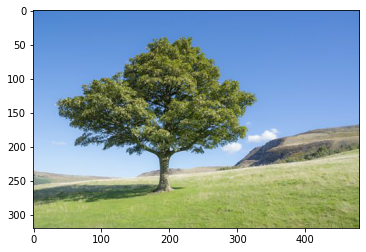

In [624]:
tree_im = io.imread('tree.jpg') 
plt.imshow(tree_im);

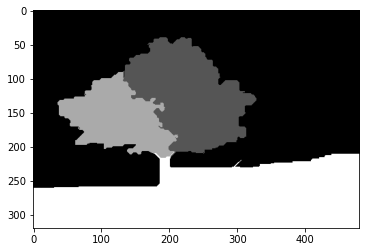

In [633]:
tree_image_felzenszwalb = segm.felzenszwalb(tree_im, scale=1, sigma=1.7, min_size=6000) 
plt.imshow(tree_image_felzenszwalb, cmap='gray')

Playing with the parameters, we can see how the mask is transormed. For choosen parameter, the segmentation is good enough.

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  """Entry point for launching an IPython kernel.


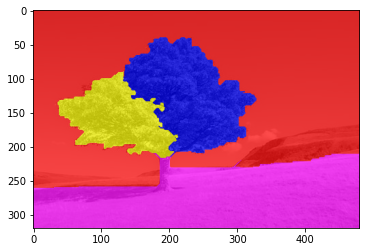

In [635]:
tree_image_felzenszwalb_colored = color.label2rgb(tree_image_felzenszwalb, tree_im, alpha=0.7)
plt.imshow(tree_image_felzenszwalb_colored)

# kidney photo

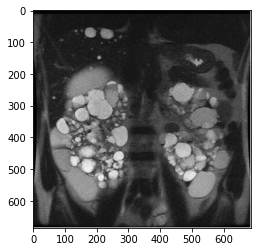

In [636]:
kidney_im = io.imread('kidney.png') 
plt.imshow(kidney_im, cmap='gray')

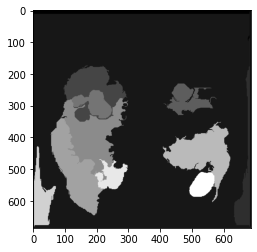

In [637]:
kidney_image_felzenszwalb = segm.felzenszwalb(kidney_im, scale=200, sigma=1.6, min_size=4000) 
plt.imshow(kidney_image_felzenszwalb, cmap='gray')

C:\Users\Christina\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  """Entry point for launching an IPython kernel.


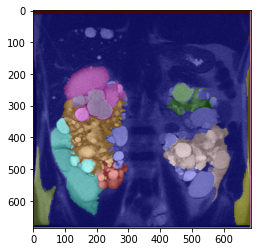

In [638]:
kidney_image_felzenszwalb_colored = color.label2rgb(kidney_image_felzenszwalb, kidney_im, alpha=0.3)
plt.imshow(kidney_image_felzenszwalb_colored)

# algorithm from scrach

based on the implemantation of Felzenszwalb & D. Huttenlocher.

In [586]:
class disjoint:
    def __init__(self, num_node):
        self.parent = [i for i in range(num_node)] #parents
        self.rank = [0 for i in range(num_node)] #rank
        self.size = [1 for i in range(num_node)] #size
        self.num = num_node

    def size_of(self, x):
        #find size
        return self.size[x]

    def find(self, x):
        #finds the parents
        if self.parent[x] == x:
            return x

        self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def merge(self, x, y):
        x = self.find(x)
        y = self.find(y)

        if x != y:
            if self.rank[x] > self.rank[y]:
                x, y = y, x

            self.parent[x] = y
            self.size[y] += self.size[x]
            if self.rank[x] == self.rank[y]:
                self.rank[y] += 1

            self.num -= 1

In [410]:
def build_edge(img,cols, x1, y1, x2, y2):
    
    node_1 =  y1 * cols + x1
    node_2 =  y2 * cols + x2
    
    r = (img[0][y1, x1] - img[0][y2, x2]) ** 2
    g = (img[1][y1, x1] - img[1][y2, x2]) ** 2
    b = (img[2][y1, x1] - img[2][y2, x2]) ** 2
    w = math.sqrt(r + g + b)
    
    return (node_1, node_2, w)

In [411]:
def build_graph(img,cols,rows):
    #use grid graph, so suppose for each pixels 4 neig

    graph = []
    for y in range(rows):
        for x in range(cols):
            if x < cols - 1:
                graph.append(build_edge(img,cols, x, y, x + 1, y))
            if y < rows - 1:
                graph.append(build_edge(img,cols, x, y, x, y + 1))
            if x < cols - 1 and y < rows - 1:
                graph.append(build_edge(img,cols, x, y, x + 1, y + 1))
            if x < cols - 1 and y > 0:
                graph.append(build_edge(img,cols, x, y, x + 1, y - 1))

    return graph

In [412]:
img = io.imread('tree.jpg') 
sigma=1.2
smooth_img = gaussian(img,sigma)
height, width, channel = img.shape

graph = build_graph(smooth_img, width, height)
weight = lambda edge: edge[2]
sorted_graph = sorted(graph, key=weight)

The sorted graph contains the edges sorted by weight, the weight is saved in the third position of each element(edge) in the graph. Each element is in format edge=(node1,node2,w)

In [413]:
sorted_graph[0]

(10, 11, 0.0)

In [588]:
def get_threshold(k, size):
    return (k / size)

In [415]:
def segment(graph, num_of_nodes, k):
    
    # make a disjoint-set forest
    seg= disjoint(num_of_nodes)
    threshold = [get_threshold(k, 1)] * num_of_nodes
    
    for i in graph:
    
        vi=seg.find(i[0]) #node1
        vj=seg.find(i[1]) #node2
        w=i[2] #weight
        if vi != vj:
            if w <= threshold[vi] and w <= threshold[vj]:
                seg.merge(vi, vj)
                parent = seg.find(vi)
                threshold[parent] = w + get_threshold(k, seg.size_of(parent))
        
    return seg    

In [589]:
def edit_small_clusters(seg, graph, min_size):
    #min_size: minimum component cluster size 

    for i in graph:
        vi = seg.find(i[0])
        vj = seg.find(i[1])

        if vi != vj:
            if seg.size_of(vi) < min_size or seg.size_of(vj) < min_size:
                seg.merge(vi, vj)

    return seg

In [590]:
def segment_image(seg, width, height):
    #pick random colors for each component
    random_color = lambda: (int(rand.random() * 255), int(rand.random() * 255), int(rand.random() * 255))
    #r = rand.random()
    #b = rand.random()
    #g = rand.random()
    #random_color = (r, g, b)
    color = [random_color() for i in range(width * height)]

    image = np.zeros((height, width, 3), np.uint8)

    for y in range(height):
        for x in range(width):
            color_idx = seg.find(y * width + x)
            image[y, x] = color[color_idx]

    return image

In [591]:
def gaussian(img, sigma):
    data = np.asarray(img, dtype=float)
    gaussian_img = cv2.GaussianBlur(data, (5, 5), sigma)
    b, g, r = cv2.split(gaussian_img)
    smooth_img = (r, g, b)
    return smooth_img

# Trials

# Tree image 

for trying the algorithm in one other picture, the below code should be copied and pasted, change only the name of the photo. The photo should be in the same directory of Jupyter notebook.

the steps below are:
1. set sigma, min_size, k
2. read the image
3. call function gaussian(image)
4. keep the dimensions of the image
5. call function build_graph and sort this graph by weight
6. call segment, call edit_small_clusters, segment image
7. plot the segmented image.

In [647]:
sigma = 1.0
k = 300
min_size = 15

img = io.imread('tree.jpg') 

smooth_img = gaussian(img,sigma)

height, width, channel = img.shape

graph = build_graph(smooth_img,width,height)
weight = lambda edge: edge[2]
sorted_graph = sorted(graph, key=weight)

seg = segment(sorted_graph, width * height, k)
seg = edit_small_clusters(seg, sorted_graph, min_size)

the_img = segment_image(seg, width, height)

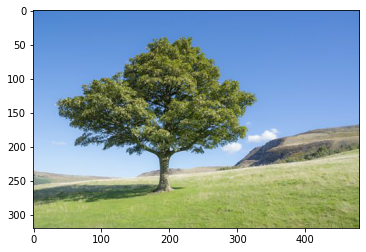

In [648]:
plt.imshow(img)

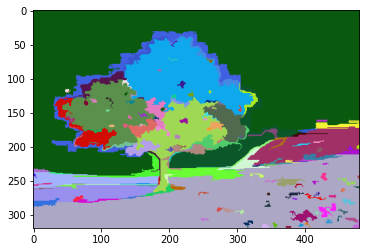

In [649]:
plt.imshow(the_img)

# walking pedestrians image

In [660]:
sigma = 0.8
k = 500
min_size = 100

img = io.imread('walking.jpg')
smooth_img = gaussian(img,sigma)


height, width, channel = img.shape
graph = build_graph(smooth_img,width,height)

weight = lambda edge: edge[2]
sorted_graph = sorted(graph, key=weight)

seg = segment(sorted_graph, width * height, k)
seg = merge_groups(seg, sorted_graph, min_size)

the_img = generate_image(seg, width, height)

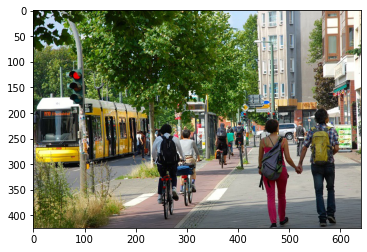

In [656]:
plt.imshow(img)

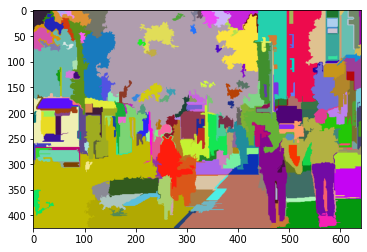

In [661]:
plt.imshow(the_img)

# polycystic kidney image

In [668]:
sigma = 1.6
k = 200
min_size = 4000

img = cv2.imread('kidney.png') 

smooth_img=gaussian(img,sigma)

height, width, channel = img.shape
graph = build_graph(smooth_img,width,height)

weight = lambda edge: edge[2]
sorted_graph = sorted(graph, key=weight)

seg = segment(sorted_graph, width * height, k)
seg = merge_groups(seg, sorted_graph, min_size)

the_img = generate_image(seg, width, height)

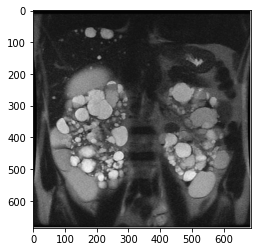

In [669]:
plt.imshow(img)

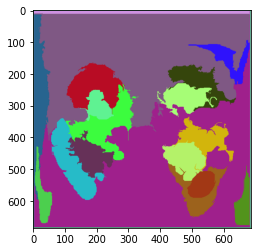

In [670]:
plt.imshow(the_img)